# **CUSTOMER SEGMENTATION USING KMEANS**

# 0. Import Library

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 1. Load Dataset

This dataset contains all purchases made for an online retail company based in the UK during an eight month period.

In [ ]:
df = pd.read_csv('https://www.dropbox.com/s/mqe0x79bzbyguew/OnlineRetail.csv?dl=1', encoding = "unicode_escape")

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# 2. Clean Data

In [ ]:
# Focus on UK market only and drop the rest of the data
df = df[df['Country'] == 'United Kingdom']
# Drop the column country since there is only UK 
df.drop(columns = 'Country', inplace = True)

# Drop duplicated
df.drop_duplicates(inplace = True)
# The analysis is about Customer. Drop all the transactions that have NaN in CustomerID.
df=df[df['CustomerID'].notna()]
# Convert the InvoiceDate to time-series datatype
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356728 entries, 0 to 541893
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    356728 non-null  object        
 1   StockCode    356728 non-null  object        
 2   Description  356728 non-null  object        
 3   Quantity     356728 non-null  int64         
 4   InvoiceDate  356728 non-null  datetime64[ns]
 5   UnitPrice    356728 non-null  float64       
 6   CustomerID   356728 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 21.8+ MB


In [ ]:
# Feature Engineer: Compute new columns called Revenue = Quantity * Unit Price
df['Revenue'] = df['Quantity'] * df['UnitPrice']

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,20.34


# 3. Customer Segmentation using the RFM metrics

<img src='https://d35fo82fjcw0y8.cloudfront.net/2018/03/01013508/Incontent_image.png'>

**RFM stands for Recency - Frequency - Monetary Value.**

RFM analysis numerically ranks a customer in each of these three categories, generally on a scale of 1 to 5 (the higher the number, the better the result). The "best" customer would receive a top score in every category.

Theoretically we will have segments like below:

- 🥲 **LOW VALUES**: Customers who are less active than others, not very frequent buyer/visitor and generates very low or zero net revenue.
- 🙂 **MID VALUES**: In the middle of everything. Using our platform oftently (but not as much as our High Values), fairly frequent and generates moderate revenue.
- 🤑 **HIGH VALUES**: The group we don’t want to lose. High Revenue, Frequency and low Inactivity.

## 3a / RECENCY

- The more recently a customer has made a purchase with a company, the more likely he or she will continue to keep the business and brand in mind for subsequent purchases
- Such information can be used to remind recent customers to revisit the business soon to continue meeting their purchase needs. Marketing efforts could be made to remind them that it has been a while since their last transaction while offering them an incentive to rekindle their interests.

How can we calculate Recency in this dataset? 

1. Find out most recent purchase date of each customer and **see how many days they are inactive for**
2. After having number of inactive days for each customer, **we will apply K-means clustering to assign customers a recency score.**

### STEP 1: Find the Recency valuf of each customer

1. Find the latest InvoiceDate for each Customer
2. Find the differences between the latest date of our entire dataset and the latest InvoiceDate for each customer. This will be the Recency

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,20.34


In [ ]:
# Step 1: Find the Max Purchase Date of each customer
recency = df.groupby('CustomerID')[['InvoiceDate']].max().reset_index().rename(columns = {'InvoiceDate': "MaxPurchaseDate"})
recency

,CustomerID,MaxPurchaseDate
0,12346.0,2011-01-18 10:17:00
1,12747.0,2011-12-07 14:34:00
2,12748.0,2011-12-09 12:20:00
3,12749.0,2011-12-06 09:56:00
4,12820.0,2011-12-06 15:12:00
...,...,...
3945,18280.0,2011-03-07 09:52:00
3946,18281.0,2011-06-12 10:53:00
3947,18282.0,2011-12-02 11:43:00
3948,18283.0,2011-12-06 12:02:00


In [ ]:
# Step 2: Compute the new column called Recency, which is the duration of time between each customer's max purchase date and the whole dataset max purchase date.
recency['Recency'] =  df['InvoiceDate'].max() - recency['MaxPurchaseDate']
recency

,CustomerID,MaxPurchaseDate,Recency
0,12346.0,2011-01-18 10:17:00,325 days 02:32:00
1,12747.0,2011-12-07 14:34:00,1 days 22:15:00
2,12748.0,2011-12-09 12:20:00,0 days 00:29:00
3,12749.0,2011-12-06 09:56:00,3 days 02:53:00
4,12820.0,2011-12-06 15:12:00,2 days 21:37:00
...,...,...,...
3945,18280.0,2011-03-07 09:52:00,277 days 02:57:00
3946,18281.0,2011-06-12 10:53:00,180 days 01:56:00
3947,18282.0,2011-12-02 11:43:00,7 days 01:06:00
3948,18283.0,2011-12-06 12:02:00,3 days 00:47:00


In [ ]:
# Step 3: Convert the Recency to days
recency['Recency'] = recency['Recency'].dt.days
recency

,CustomerID,MaxPurchaseDate,Recency
0,12346.0,2011-01-18 10:17:00,325
1,12747.0,2011-12-07 14:34:00,1
2,12748.0,2011-12-09 12:20:00,0
3,12749.0,2011-12-06 09:56:00,3
4,12820.0,2011-12-06 15:12:00,2
...,...,...,...
3945,18280.0,2011-03-07 09:52:00,277
3946,18281.0,2011-06-12 10:53:00,180
3947,18282.0,2011-12-02 11:43:00,7
3948,18283.0,2011-12-06 12:02:00,3


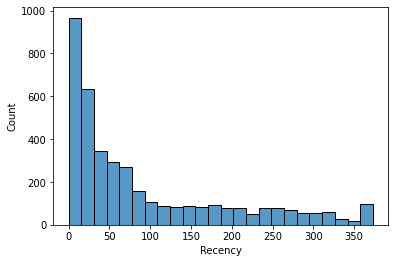

In [ ]:
# Plot a histogram to show the distribution of Recency
# YOUR CODE HERE
sns.histplot(data = recency, x = 'Recency')

### STEP 2: Apply K-Means on Recency to cluster customers.

In [ ]:
X = recency[['Recency']]

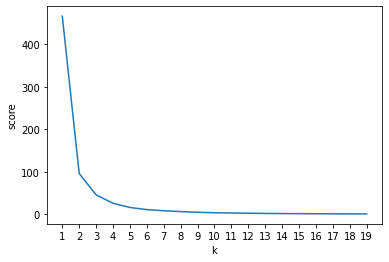

In [ ]:
# Using Elbow method to approximate the number of clusters.
# YOUR CODE HERE
from sklearn.cluster import KMeans
k_values = range(1,20)
k_mean_models = [KMeans(n_clusters=k) for k in k_values]
scores = [kmean.fit(X).score(X) for kmean in k_mean_models]

norm_scores = [score/max(scores) for score in scores]

plt.plot(k_values, norm_scores)
plt.xlabel('k')
plt.xticks(range(1, 20))
plt.ylabel('score');

In [ ]:
# Call, fit the KMean model, and run prediction to find the cluster of each customer.
# YOUR CODE HERE
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

y_kmeans = kmeans.predict(X)

In [ ]:
y_kmeans

array([0, 1, 1, ..., 1, 1, 1], dtype=int32)

In [ ]:
# Create a new column called RecencyCluster to save the cluster information
# YOUR CODE HERE
recency['RecencyCluster'] = y_kmeans

In [ ]:
recency.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,558.0,294.433692,45.277184,225.0,256.0,287.0,329.00,373.0
1,2660.0,30.516541,25.207721,0.0,9.0,24.0,49.25,92.0
2,732.0,154.517760,38.145893,93.0,120.0,154.0,186.00,224.0


We have sucessfully cluster our customers. However, in order to use the cluster indices to be our Recency Score, we need to rearrange the indices a bit. The higher the recency, the less the value that customer brings to us, so higher recency should result in a lower score. We will use the function below for this task (Make sure to set ascending = False)

In [ ]:
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    """Rearange cluster in such order that the higher the recency, the less the value 
       that customer brings to us, so higher recency should result in a lower score."""

    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    
    return df_final

recency = order_cluster('RecencyCluster', 'Recency', recency, False)

In [ ]:
recency.head()

,CustomerID,MaxPurchaseDate,Recency,RecencyCluster
0,12346.0,2011-01-18 10:17:00,325,0
1,12829.0,2011-01-21 12:56:00,321,0
2,12831.0,2011-03-22 13:02:00,261,0
3,12834.0,2011-03-02 09:49:00,282,0
4,12845.0,2011-03-17 13:34:00,266,0


In [ ]:
recency.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,558.0,294.433692,45.277184,225.0,256.0,287.0,329.00,373.0
1,732.0,154.517760,38.145893,93.0,120.0,154.0,186.00,224.0
2,2660.0,30.516541,25.207721,0.0,9.0,24.0,49.25,92.0


Higher score for Recency = better customers (as their inactive time is low)

## 3b / FREQUENCY

The frequency of a customer’s transactions may be affected by factors such as the type of product, the price point for the purchase, and the need for replenishment or replacement. 

In order to increase customers' frequency, we can try to predict their purchase cycle, for example when a customer needs to buy new groceries, marketing efforts could be directed towards reminding them to visit the business when items such as eggs or milk have been depleted.

### STEP 1: Calculate the Frequency 

✍🏼 We just need to find total number orders for each customer. Simply that! 🙆🏻‍♂️

In [ ]:
# Find the total number of orders of each customer.
frequency = df.groupby('CustomerID')[['InvoiceNo']].count().reset_index().rename(columns = {"InvoiceNo":'Frequency'})

In [ ]:
# Your answer should look like this
frequency

,CustomerID,Frequency
0,12346.0,2
1,12747.0,103
2,12748.0,4459
3,12749.0,231
4,12820.0,59
...,...,...
3945,18280.0,10
3946,18281.0,7
3947,18282.0,13
3948,18283.0,721


(0.0, 500.0)

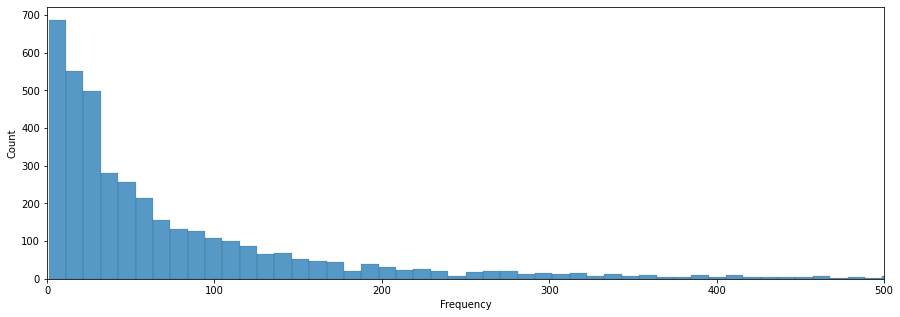

In [ ]:
plt.figure(figsize = (15,5))
sns.histplot(data = frequency, x = 'Frequency')
plt.xlim(0, 500)

### STEP 2: Apply K-Means

In [ ]:
X1 = frequency[['Frequency']].values

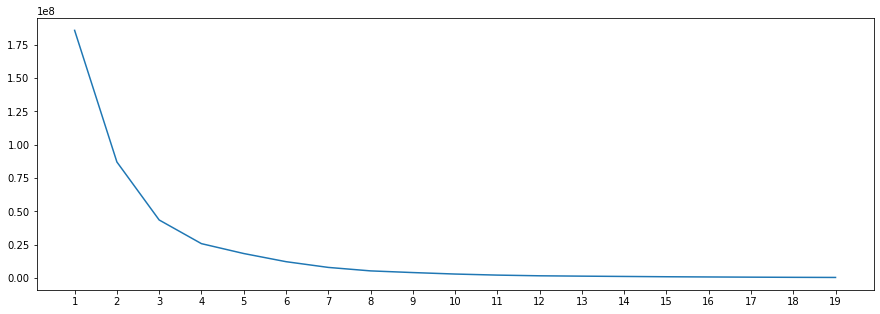

In [ ]:
# Using Elbow method to approximate the number of clusters.
# YOUR CODE HERE
k_range = range(1, 20)

wcss = []
for i in k_range:
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X1)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(15, 5))
plt.plot(k_range, wcss)
plt.xticks(k_range)
plt.show()

In [ ]:

# Call, fit the KMean model, and run prediction to find the cluster of each customer.
# YOUR CODE HERE
kmeans = KMeans(n_clusters = 3, random_state = 42)
clusters = kmeans.fit_predict(X1)

In [ ]:
# Create a new column called FrequencyCluster to save the cluster information
# YOUR CODE HERE
frequency['FrequencyCluster'] = clusters
frequency

,CustomerID,Frequency,FrequencyCluster
0,12346.0,2,0
1,12747.0,103,0
2,12748.0,4459,1
3,12749.0,231,0
4,12820.0,59,0
...,...,...,...
3945,18280.0,10,0
3946,18281.0,7,0
3947,18282.0,13,0
3948,18283.0,721,2


In [ ]:
# Re-arange the Frequency clusters
frequency = order_cluster('FrequencyCluster', 'Frequency', frequency, True)

In [ ]:
# Your answer might look like this.
frequency.head()

,CustomerID,Frequency,FrequencyCluster
0,12346.0,2,0
1,12747.0,103,0
2,12749.0,231,0
3,12820.0,59,0
4,12821.0,6,0


In [ ]:
# View the descriptive statistics report of each customer group.
frequency.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3684.0,57.720413,57.722425,1.0,15.75,36.0,82.25,268.0
1,263.0,481.699620,309.272066,270.0,312.50,392.0,518.50,2759.0
2,3.0,5799.666667,1774.543415,4459.0,4793.50,5128.0,6470.00,7812.0


As the same notation as recency clusters, high frequency number indicates better customers.

## 3c / REVENUE

Revenue shows the intention of customers to spend, or the purchasing power of customers

Note: Businesses that focus more on viewership, readership, or surfing-oriented products, could use Engagement parameters instead of Monetary factors. This results in using RFE – a variation of RFM. Also, this Engagement parameter could be defined based on bounce rate, visit duration, number of pages visited, time spent per page, etc.

In [ ]:
# Calculate the Total Revenue made by each customer
revenue = df.groupby('CustomerID')[['Revenue']].sum().reset_index()
revenue.head()

,CustomerID,Revenue
0,12346.0,0.00
1,12747.0,4196.01
2,12748.0,28405.56
3,12749.0,3868.20
4,12820.0,942.34


(0.0, 5000.0)

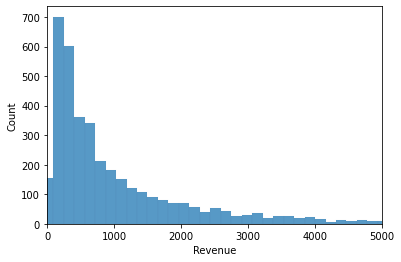

In [ ]:
sns.histplot(data= revenue, x = 'Revenue')
plt.xlim(0, 5000)

In [ ]:
# Call, fit the KMean model, and run prediction to find the cluster of each customer.
# YOUR CODE HERE
X2 = revenue[['Revenue']].values
kmeans = KMeans(n_clusters = 3, random_state = 42)
clusters = kmeans.fit_predict(X2)

In [ ]:
# Create a new column called RevenueCluster to save the cluster information
# YOUR CODE HERE
revenue['RevenueCluster'] = clusters
revenue

,CustomerID,Revenue,RevenueCluster
0,12346.0,0.00,0
1,12747.0,4196.01,0
2,12748.0,28405.56,2
3,12749.0,3868.20,0
4,12820.0,942.34,0
...,...,...,...
3945,18280.0,180.60,0
3946,18281.0,80.82,0
3947,18282.0,176.60,0
3948,18283.0,2045.53,0


In [ ]:
# Re-arange the Revenue clusters
revenue = order_cluster('RevenueCluster', 'Revenue', revenue,True)

In [ ]:
revenue.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,3921.0,1310.792062,2050.418988,-4287.63,278.15,617.05,1482.060,21535.90
1,27.0,43102.956296,16007.049228,25748.35,28532.22,36352.87,53698.715,88125.38
2,2.0,221880.330000,48872.618563,187322.17,204601.25,221880.33,239159.410,256438.49


## 3d / RFM SCORE

In [ ]:
# Merge the three tables recency, frequency and revenue together.
final_rfm = pd.merge(recency, frequency,on = 'CustomerID').drop(columns ='MaxPurchaseDate')
final_rfm = pd.merge(final_rfm, revenue, on = 'CustomerID')
final_rfm

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,12346.0,325,0,2,0,0.00,0
1,12829.0,321,0,12,0,253.05,0
2,12831.0,261,0,9,0,215.05,0
3,12834.0,282,0,18,0,312.38,0
4,12845.0,266,0,27,0,354.09,0
...,...,...,...,...,...,...,...
3945,18248.0,113,1,49,0,783.02,0
3946,18260.0,172,1,139,0,2580.15,0
3947,18262.0,139,1,13,0,149.48,0
3948,18268.0,133,1,2,0,0.00,0


In [ ]:
# Create a column called RFM_score which is the sum of the three cluster scores.
final_rfm['RFM_score'] = final_rfm['RecencyCluster'] + final_rfm['FrequencyCluster'] + final_rfm['RevenueCluster']
final_rfm.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,RFM_score
0,12346.0,325,0,2,0,0.00,0,0
1,12829.0,321,0,12,0,253.05,0,0
2,12831.0,261,0,9,0,215.05,0,0
3,12834.0,282,0,18,0,312.38,0,0
4,12845.0,266,0,27,0,354.09,0,0


In [ ]:
final_rfm['RFM_score'].value_counts()

2    2394
1     729
0     557
3     250
4      15
5       5
Name: RFM_score, dtype: int64

In [ ]:
final_rfm.groupby('RFM_score')[['Recency', 'Frequency', 'Revenue']].mean()

,Recency,Frequency,Revenue
RFM_score,,,
0,294.421903,22.513465,375.245943
1,154.850480,38.474623,647.018602
2,32.738931,72.111529,1314.639696
3,12.820000,451.268000,6507.490560
4,6.866667,833.733333,48212.756667
5,2.200000,3636.400000,113831.236000


🙆🏻‍♂️ **DISCUSSION: Stop here❗️ and take a look at the report table above. What do you think about each customer group?**

# 4. Conclusion

The scoring above clearly shows us that customers with score 8 is our best customers whereas 0 is the worst.

To keep things simple, better we name these scores:
- 0 and 1: Low Value
- 2 and 3: Mid Value
- 4 and 5: High Value

In [ ]:
# YOUR CODE HERE
def segmentation(row):
  if row['RFM_score'] in [0,1]:
    return 'Low Value'
  elif row['RFM_score'] in [2,3]:
    return 'Mid Value'
  else:
    return 'High Value'  

In [ ]:
final_rfm['Segmentation']= final_rfm.apply(segmentation, axis = 1)

In [ ]:
final_rfm.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,RFM_score,Segmentation
0,12346.0,325,0,2,0,0.00,0,0,Low Value
1,12829.0,321,0,12,0,253.05,0,0,Low Value
2,12831.0,261,0,9,0,215.05,0,0,Low Value
3,12834.0,282,0,18,0,312.38,0,0,Low Value
4,12845.0,266,0,27,0,354.09,0,0,Low Value


In [ ]:
final_rfm['Segmentation'].value_counts()

Mid Value     2644
Low Value     1286
High Value      20
Name: Segmentation, dtype: int64

Visualization to help us understand the clustering result better

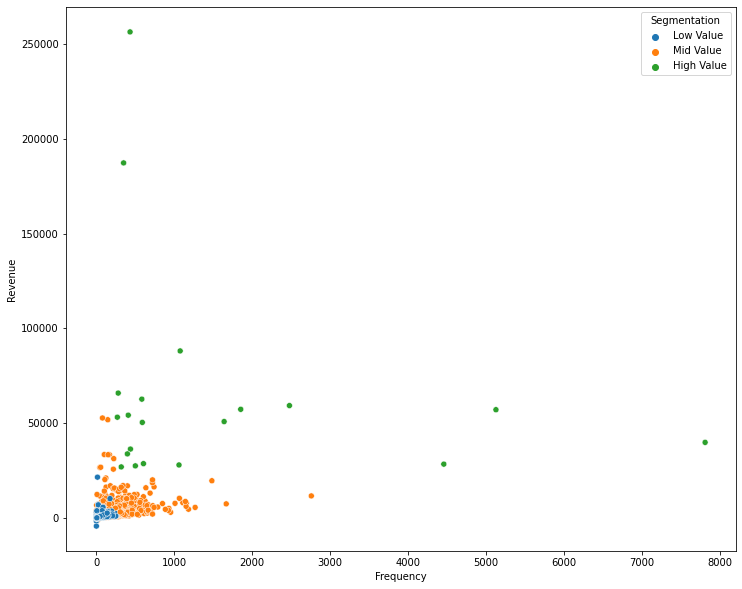

In [ ]:
plt.figure(figsize=(12,10))
sns.scatterplot(data=final_rfm, 
                x="Frequency", y="Revenue", hue="Segmentation")
plt.show()

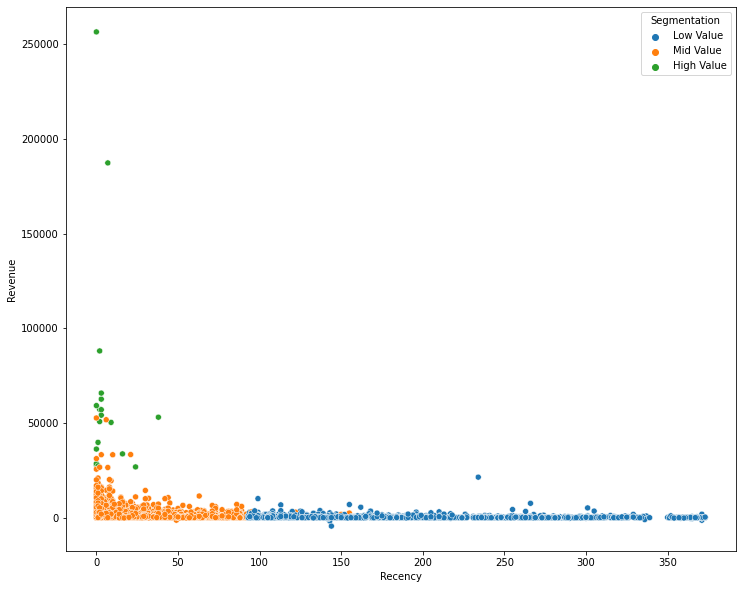

In [ ]:
plt.figure(figsize=(12,10))
sns.scatterplot(data=final_rfm, 
                x="Recency", y="Revenue", hue="Segmentation")
plt.show()

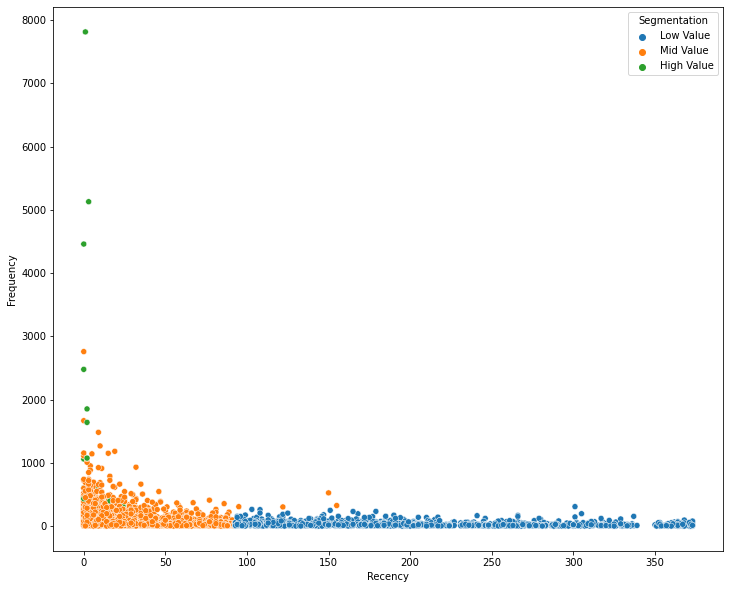

In [ ]:
plt.figure(figsize=(12,10))
sns.scatterplot(data=final_rfm, 
                x="Recency", y="Frequency", hue="Segmentation")
plt.show()